# Store Sales - Time Series Forecasting

## Exploring datasets and feature engineering

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/store-sales-time-series-forecasting/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
holidays_df = pd.read_csv(data_dir + 'holidays_events.csv')
oil_df = pd.read_csv(data_dir + 'oil.csv')
stores_df = pd.read_csv(data_dir + 'stores.csv')
transactions_df = pd.read_csv(data_dir + 'transactions.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
def draw_numeric_features(data, x=None, y=None, overlap=None):
    plt.figure(figsize=(30,10))
    plt.grid()
    sns.lineplot(data, x=x, y=y)
    if overlap is not None:
        for plot in overlap:
            sns.lineplot(data=plot[0], x=plot[1], y=plot[2])

def view_avg_of_each(cat_features: str, target: str):
    d = dict()
    cols = raw_df[cat_features].unique()
    for x in cols:
        d[x] = raw_df[raw_df[cat_features]==x][target].mean()
    return pd.Series(d, index=cols)

### `raw_df`

In [4]:
def get_info_of_date(df: pd.DataFrame):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week

In [5]:
for df in [raw_df, test_df]:
    get_info_of_date(df)

In [6]:
view_avg_of_each('year','sales')

2013    216.479530
2014    322.939786
2015    371.357193
2016    443.790297
2017    480.124466
dtype: float64

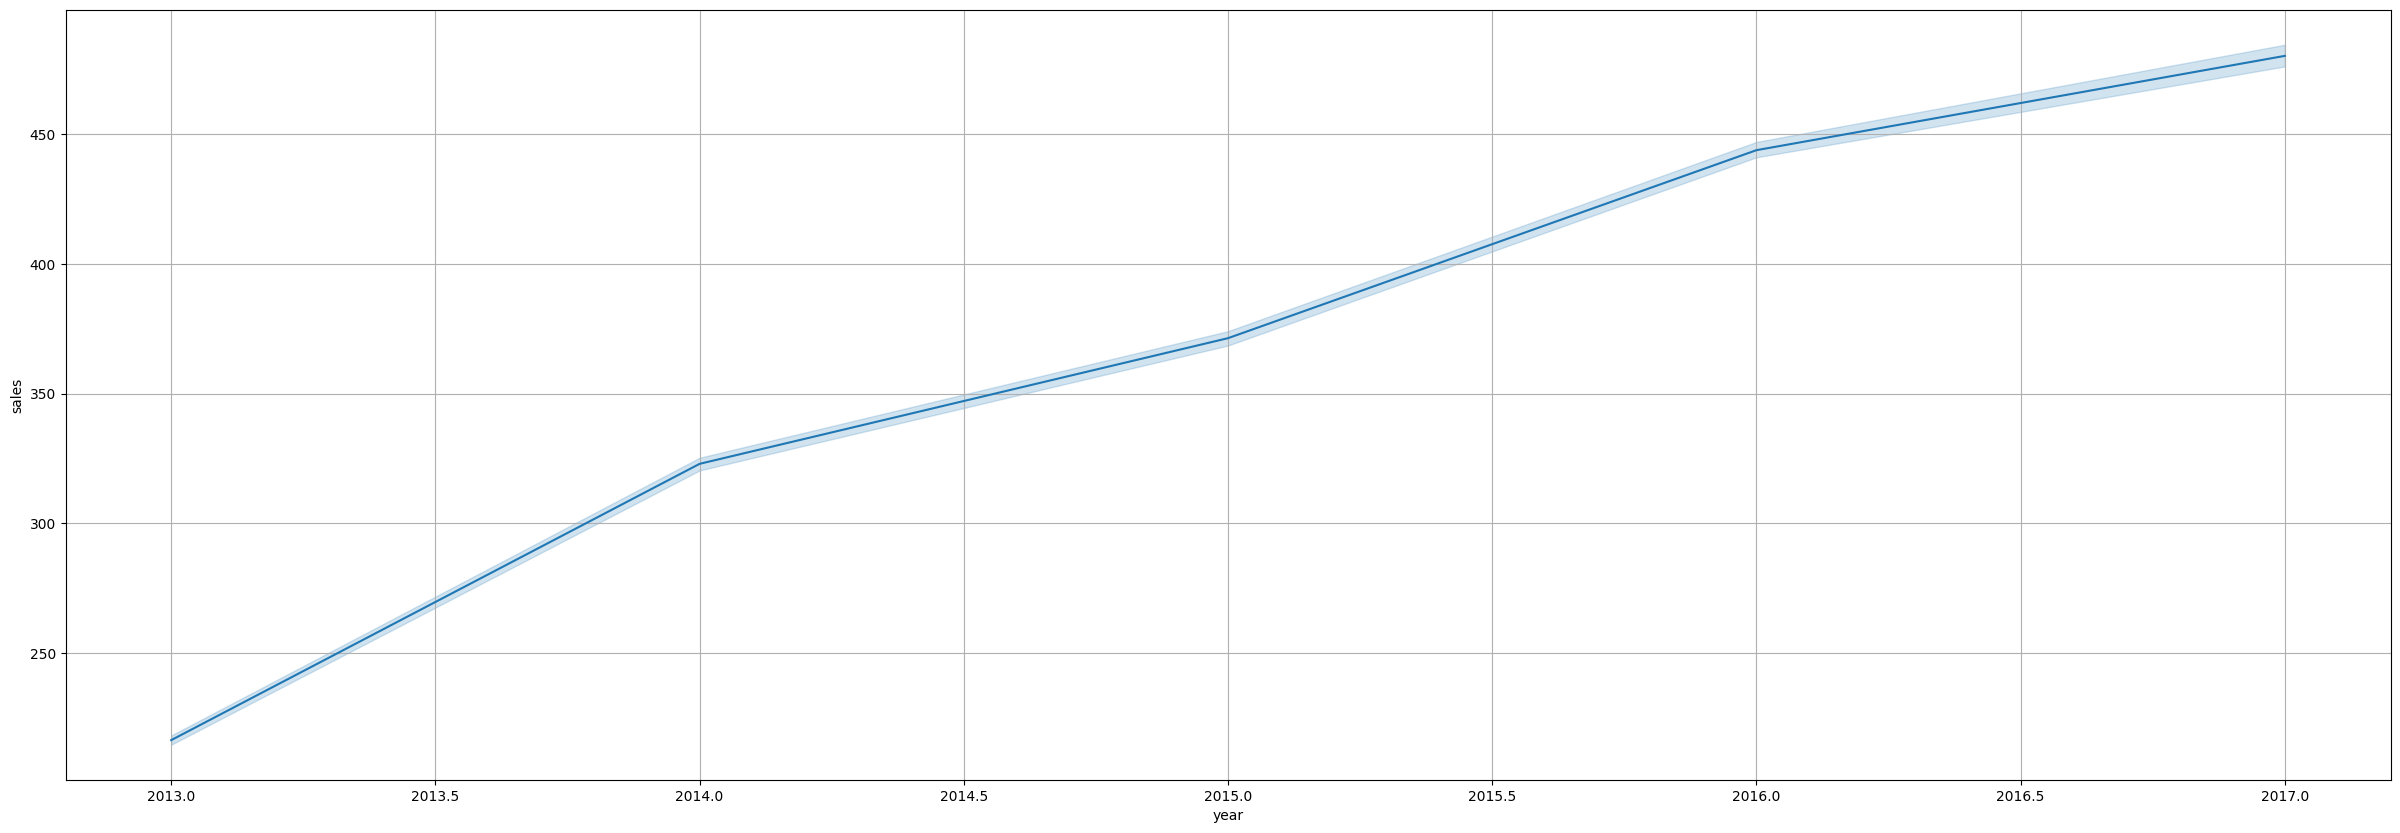

In [7]:
draw_numeric_features(raw_df, x='year', y='sales')

In [8]:
raw_df['is_weekend'] = raw_df['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)
test_df['is_weekend'] = test_df['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)

In [9]:
view_avg_of_each('is_weekend', 'sales')

0    321.629081
1    448.179995
dtype: float64

### `oil_df`

In [10]:
get_info_of_date(oil_df)

In [11]:
training_date_min = pd.to_datetime('2016-08-01')

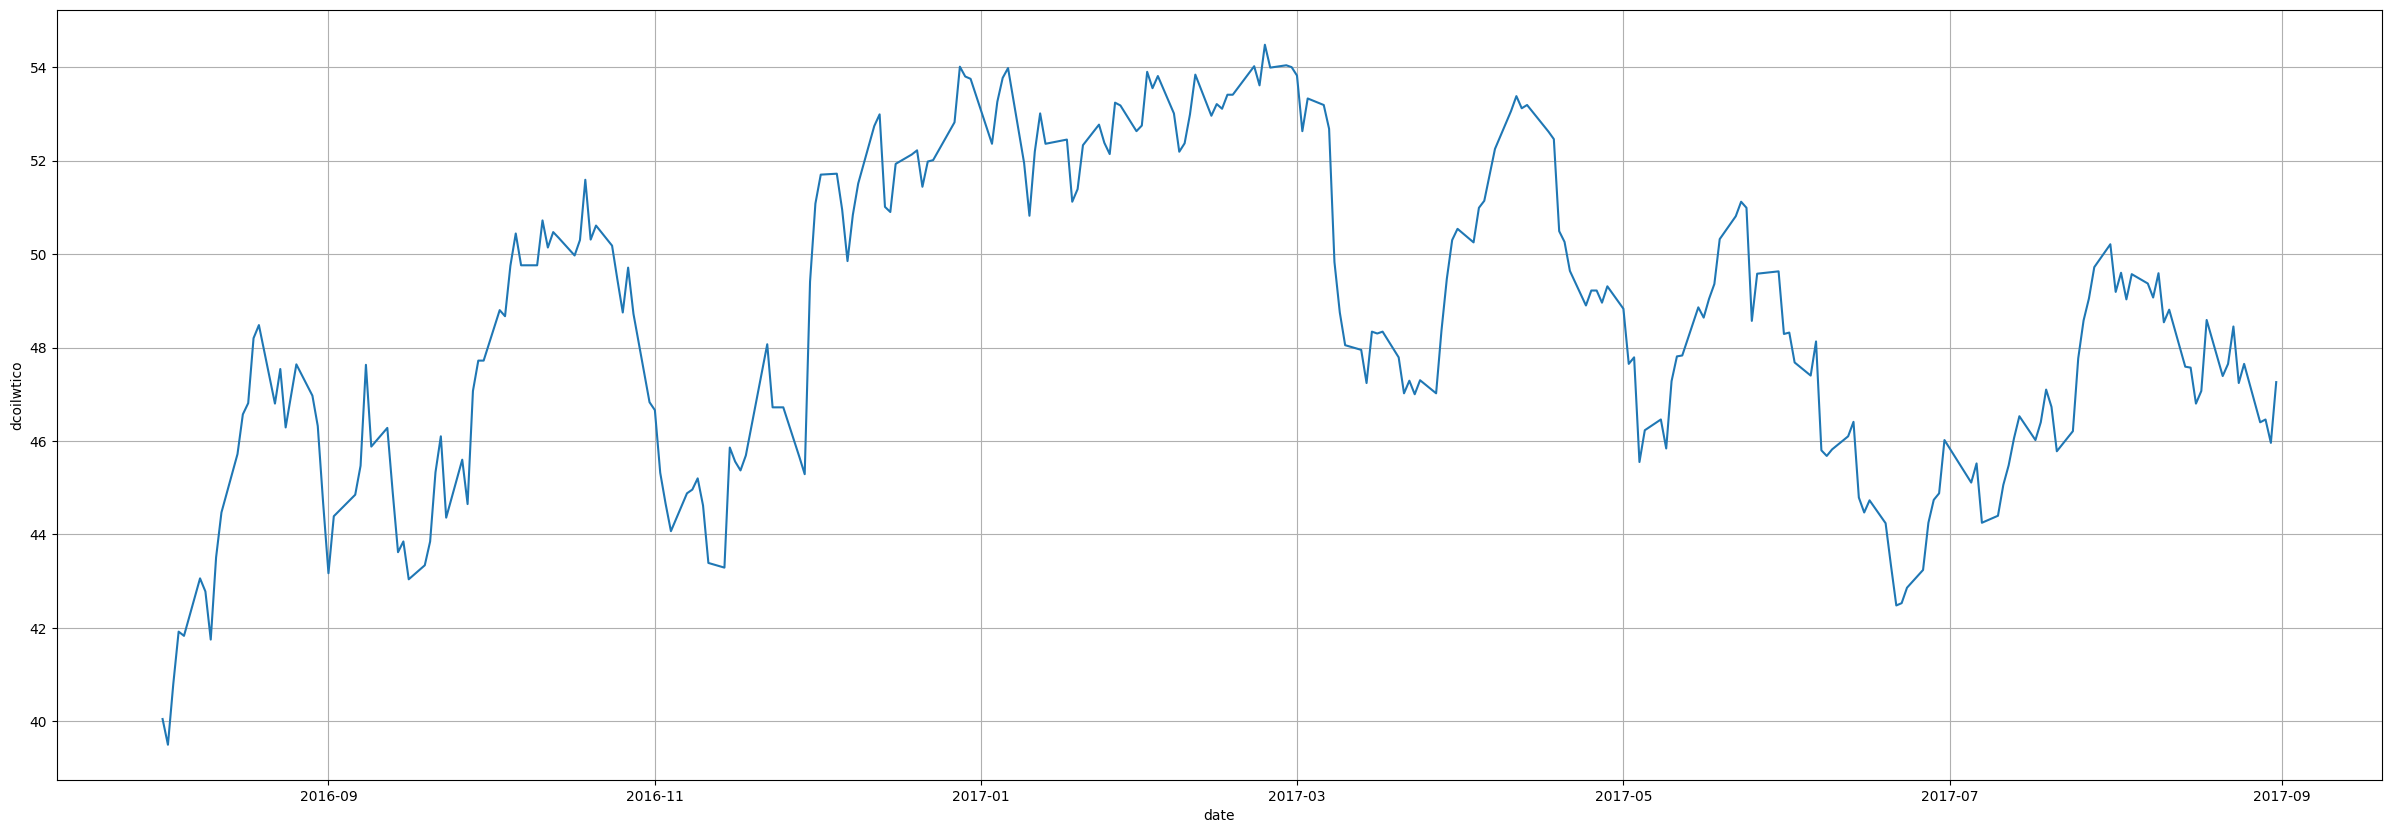

In [12]:
draw_numeric_features(oil_df[oil_df['date']>=training_date_min], x='date', y='dcoilwtico')

In [13]:
all_sales_df = raw_df.groupby(['date'])['sales'].mean().to_frame()
all_sales_df = all_sales_df[all_sales_df.index>=training_date_min]
all_sales_df

,sales
date,
2016-08-01,502.570373
2016-08-02,436.359618
2016-08-03,437.623350
2016-08-04,349.541581
2016-08-05,395.113771
...,...
2017-08-11,463.733851
2017-08-12,444.798280
2017-08-13,485.768618


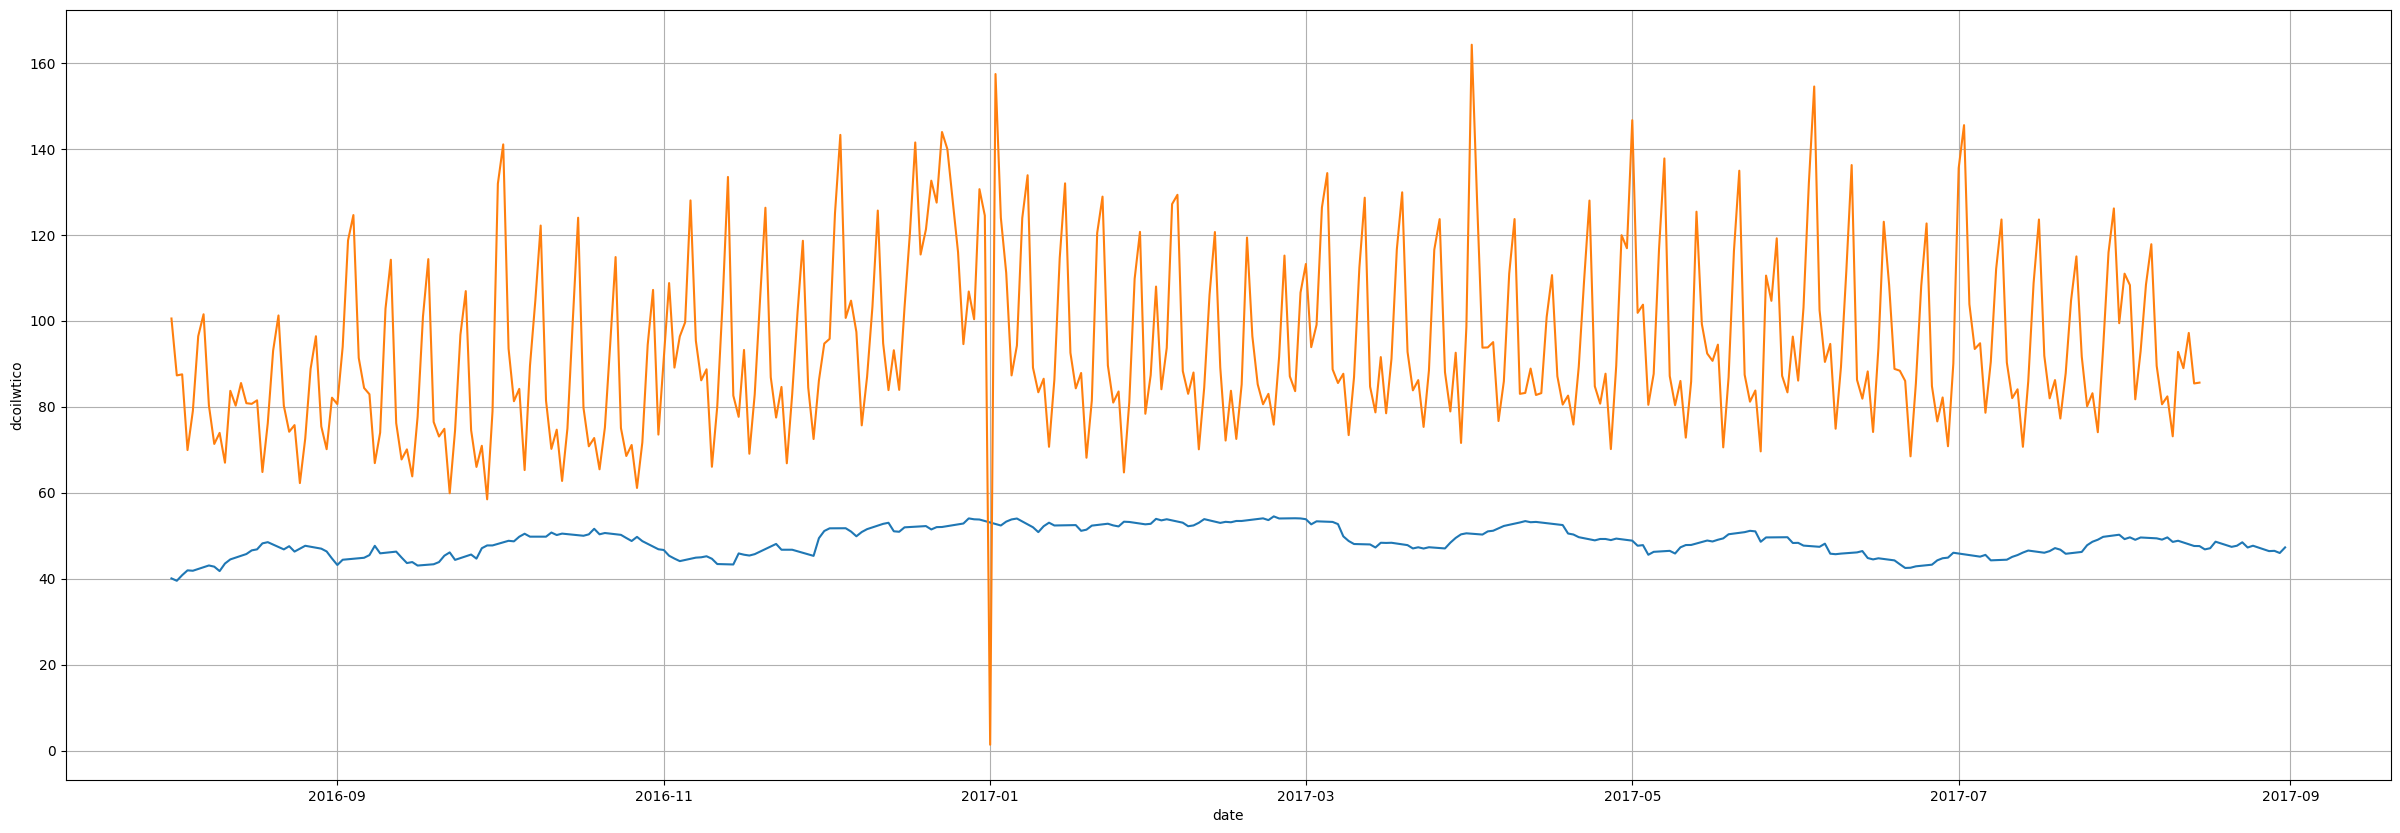

In [14]:
draw_numeric_features(oil_df[oil_df['date']>=training_date_min], x='date', y='dcoilwtico',
                      overlap=[[all_sales_df.apply(lambda x: x/5),'date','sales']])

In [15]:
oil_df['month_from'] = oil_df['year'].apply(lambda x: x-2013)*12 + oil_df['month']

In [16]:
oil_months = oil_df.groupby('month_from')['dcoilwtico'].mean()

In [17]:
oil_df.fillna({'dcoilwtico': -1.0}, inplace=True)

In [18]:
oil_df['dcoilwtico'] = oil_df.apply(lambda x: oil_months.get(x['month_from']) if x['dcoilwtico']<0 else x['dcoilwtico'], axis=1)

In [19]:
oil_df.drop(columns=['year','month','day','day_of_week','month_from'], inplace=True)

In [20]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,94.756667
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000


In [21]:
raw_df = pd.merge(left=raw_df, right=oil_df, on='date', how='left')

In [22]:
raw_df['month_from'] = raw_df['year'].apply(lambda x: x-2013)*12 + raw_df['month']

In [23]:
raw_df.fillna({'dcoilwtico': -1.0}, inplace=True)

In [24]:
raw_df['dcoilwtico'] = raw_df.apply(lambda x: oil_months.get(x['month_from']) if x['dcoilwtico']<0 else x['dcoilwtico'], axis=1)

In [25]:
test_df = pd.merge(left=test_df, right=oil_df, on='date', how='left')
test_df['month_from'] = test_df['year'].apply(lambda x: x-2013)*12 + test_df['month']
test_df.fillna({'dcoilwtico': -1.0}, inplace=True)
test_df['dcoilwtico'] = test_df.apply(lambda x: oil_months.get(x['month_from']) if x['dcoilwtico']<0 else x['dcoilwtico'], axis=1)

### stores_df

In [26]:
stores_df.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [27]:
raw_df = pd.merge(left=raw_df, right=stores_df, on='store_nbr', how='left')
test_df = pd.merge(left=test_df, right=stores_df, on='store_nbr', how='left')

In [28]:
view_avg_of_each('city','sales').head(5)

Quito        556.577090
Cayambe      509.709179
Latacunga    190.583961
Riobamba     204.921881
Ibarra       206.061866
dtype: float64

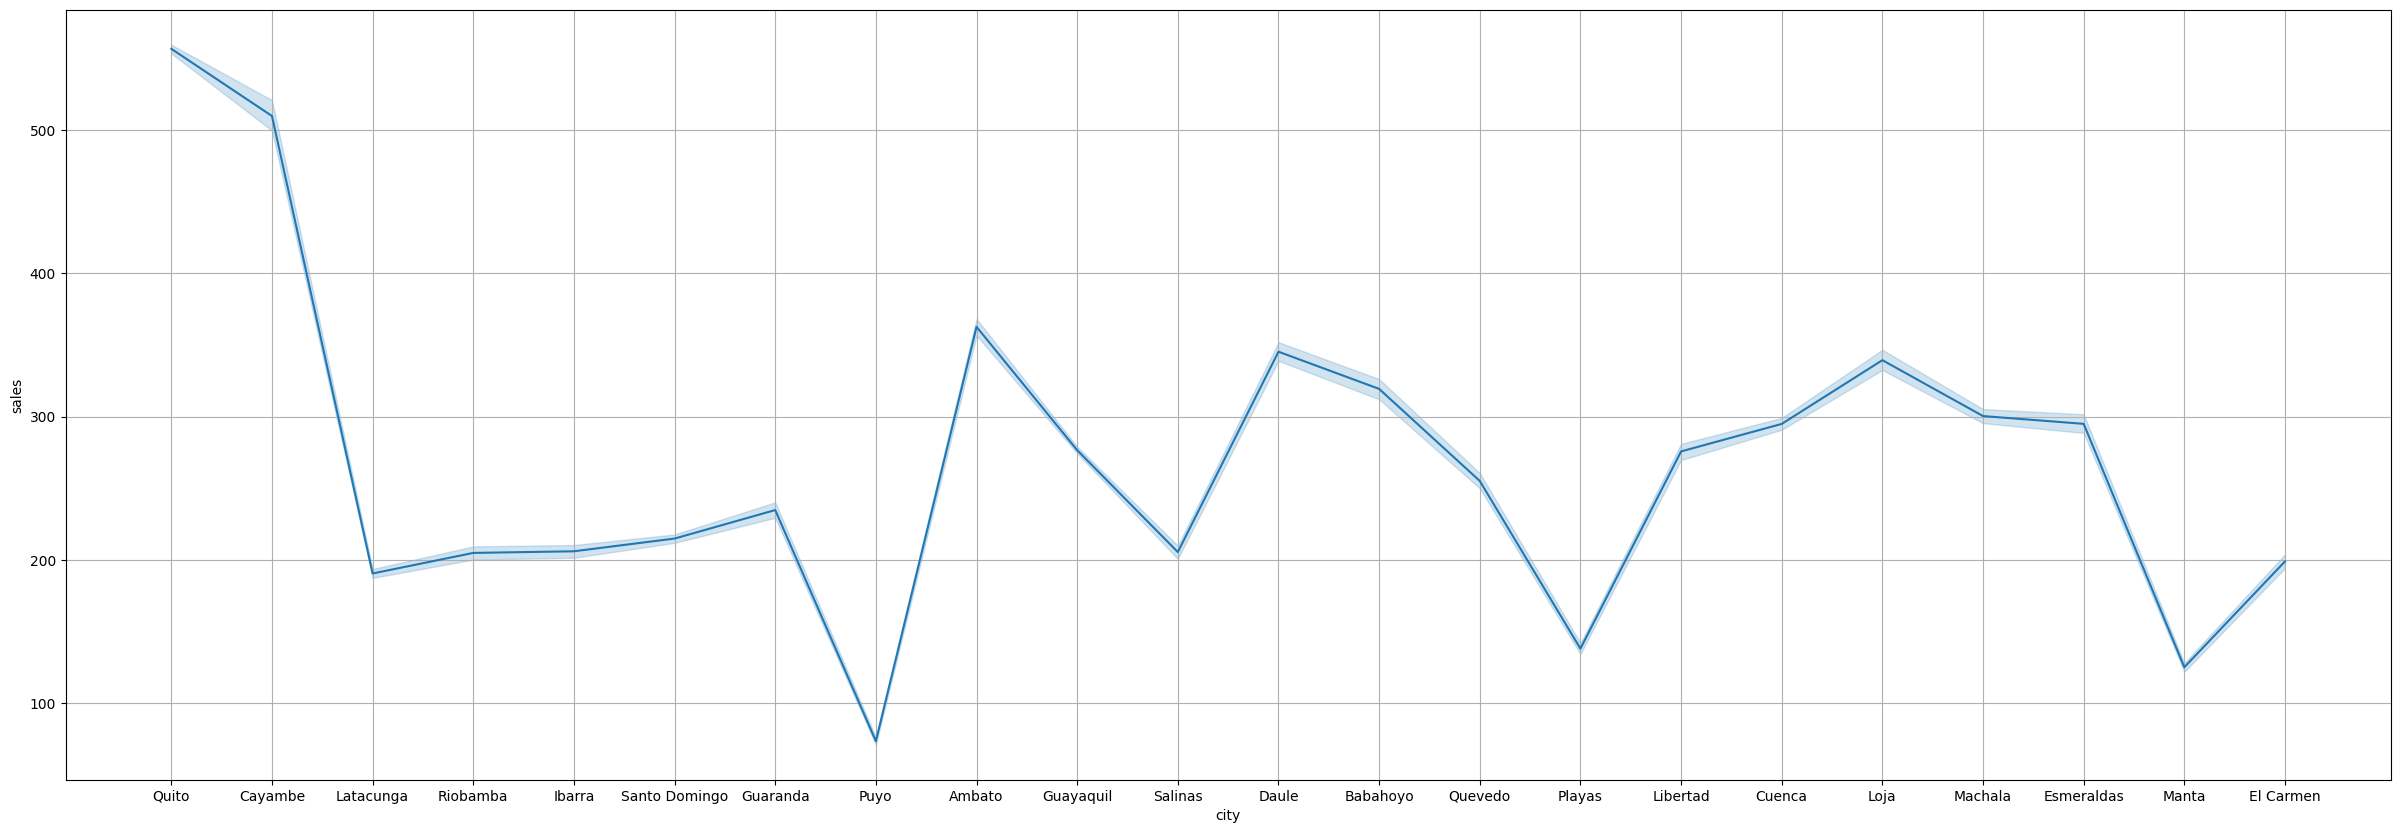

In [29]:
draw_numeric_features(raw_df, x='city', y='sales')

In [30]:
view_avg_of_each('state', 'sales').head(5)

Pichincha                         554.110358
Cotopaxi                          190.583961
Chimborazo                        204.921881
Imbabura                          206.061866
Santo Domingo de los Tsachilas    214.942315
dtype: float64

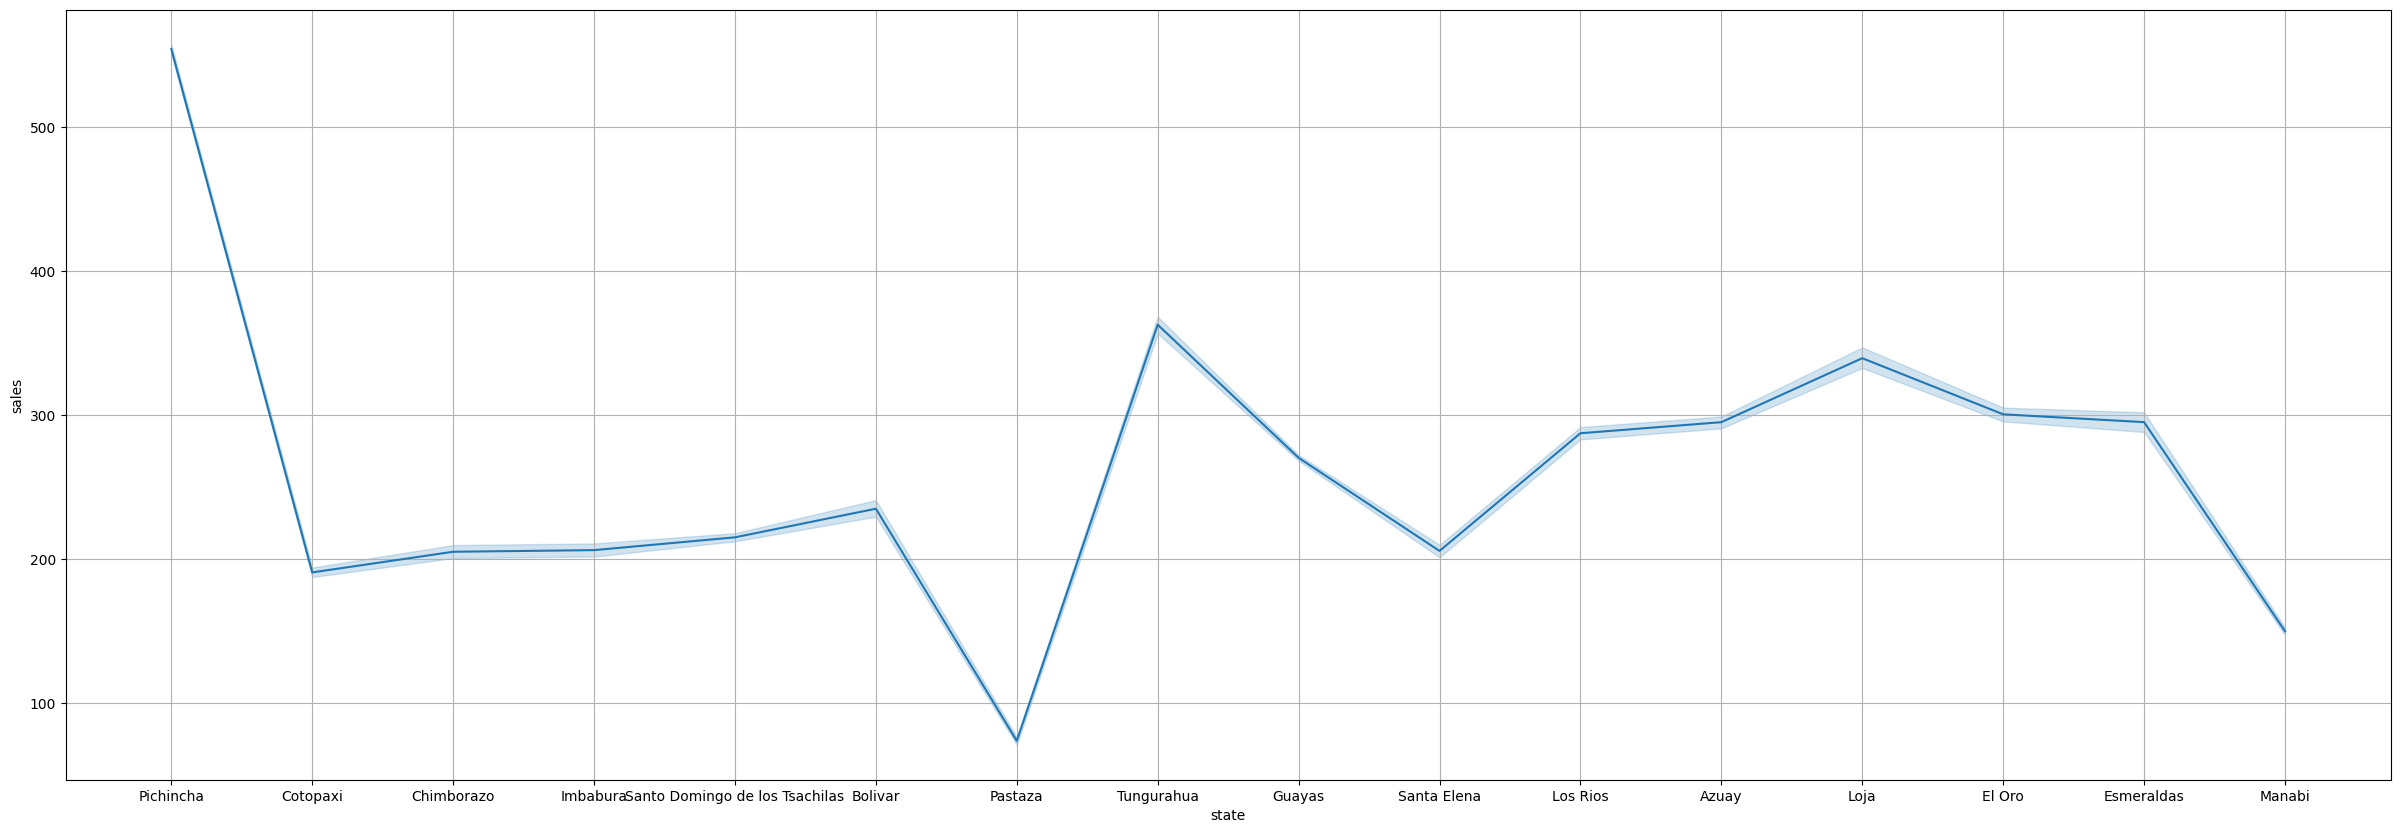

In [31]:
draw_numeric_features(raw_df, x='state', y='sales')

In [32]:
view_avg_of_each('type', 'sales')

D    350.979407
C    197.263301
B    326.739714
E    269.121301
A    705.878743
dtype: float64

In [33]:
view_avg_of_each('cluster', 'sales').head()

13    324.364108
15    199.010111
6     342.661732
7     139.261863
3     194.416262
dtype: float64

### transactions_df

In [34]:
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [35]:
get_info_of_date(transactions_df)

In [36]:
all_trans_df = transactions_df[transactions_df['date']>=training_date_min].groupby('date')['transactions'].sum().to_frame()

In [37]:
all_trans_df.head()

,transactions
date,
2016-08-01,87637
2016-08-02,85044
2016-08-03,84532
2016-08-04,78516
2016-08-05,84616


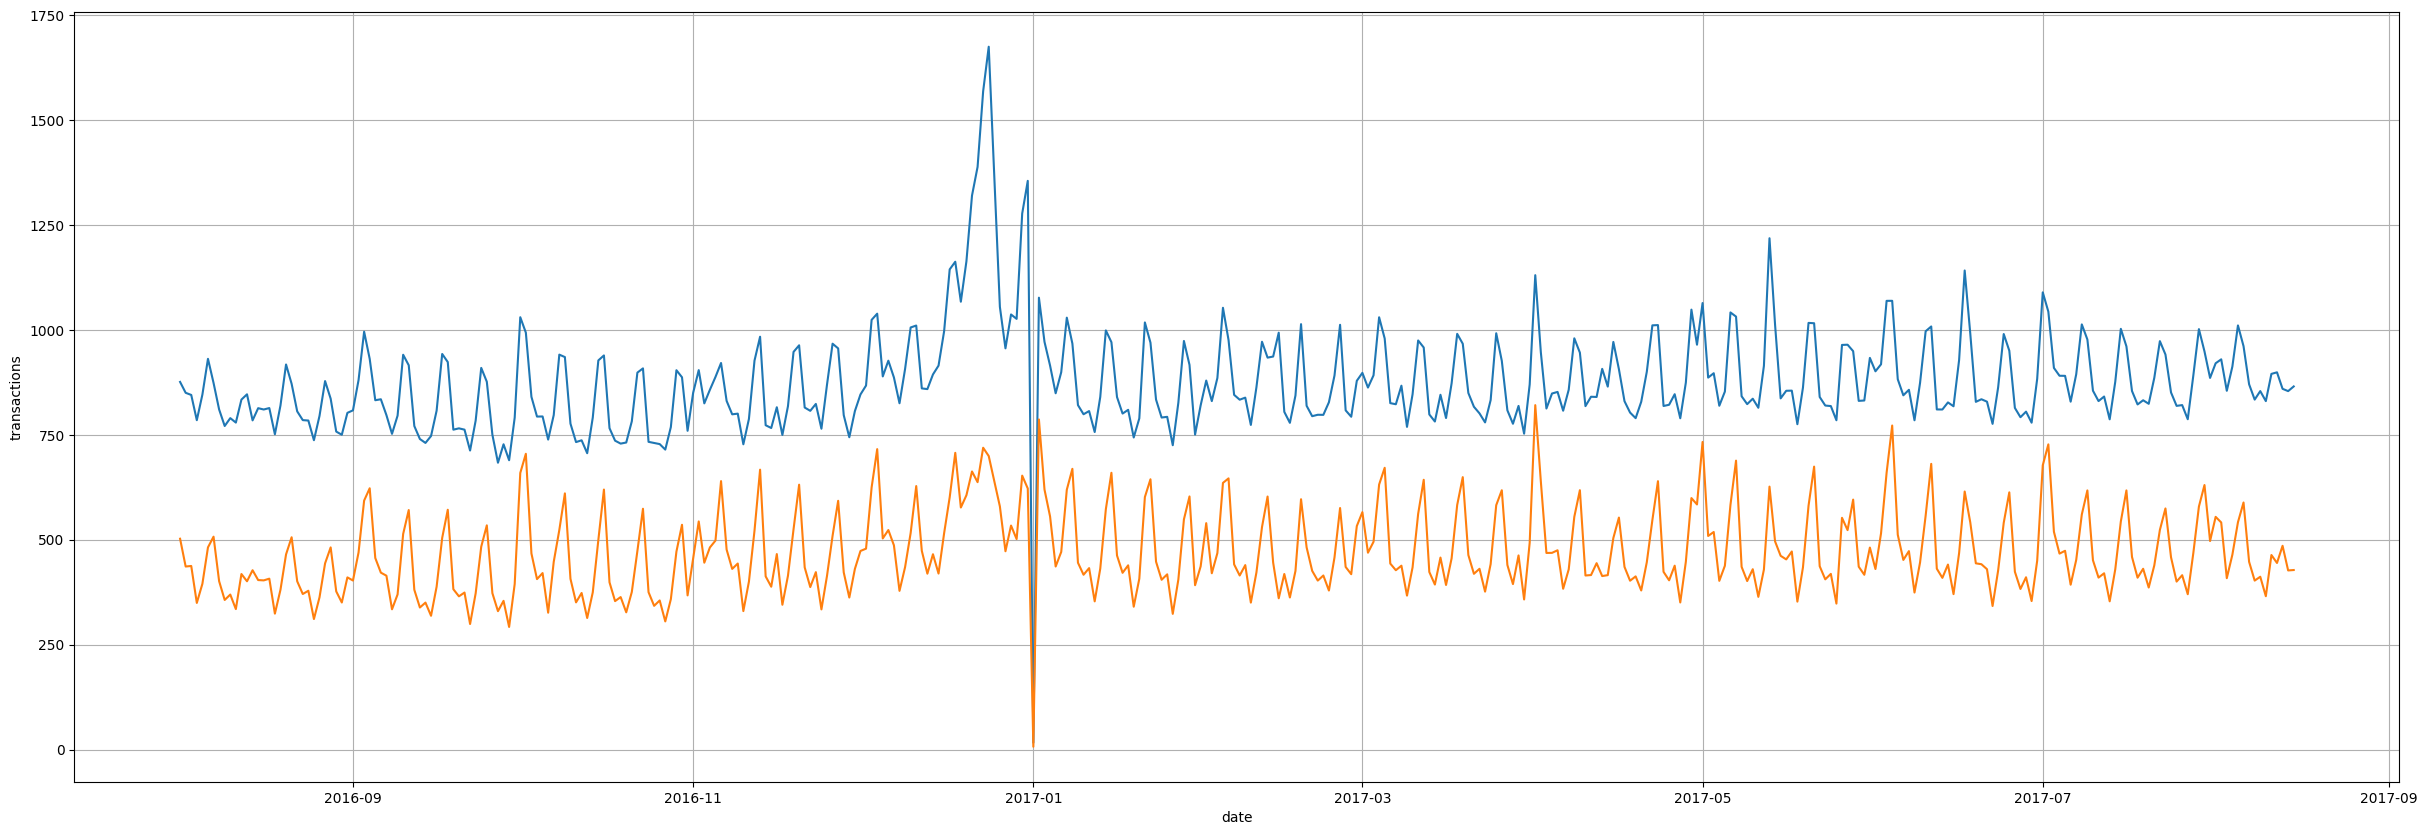

In [38]:
draw_numeric_features(all_trans_df.apply(lambda x: x/100),
                      x='date', y='transactions',
                      overlap=[[all_sales_df, 'date', 'sales']])

In [39]:
transactions_df = transactions_df[['date','store_nbr', 'transactions']]
transactions_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [40]:
rows_to_drop = all_trans_df[(all_trans_df.index > pd.to_datetime("2016-12-20")) & (all_trans_df.index < pd.to_datetime("2017-01-03"))]

In [41]:
rows_to_drop.index

DatetimeIndex(['2016-12-21', '2016-12-22', '2016-12-23', '2016-12-24',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31', '2017-01-01', '2017-01-02'],
              dtype='datetime64[ns]', name='date', freq=None)

In [42]:
raw_df = pd.merge(left=raw_df, right=transactions_df, on=['date','store_nbr'], how='left')
test_df = pd.merge(left=test_df, right=transactions_df, on=['date','store_nbr'], how='left')

### holidays_df

In [43]:
holidays_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [44]:
get_info_of_date(holidays_df)

In [45]:
holidays_df['locale'].value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [46]:
national_hol_days = holidays_df[(holidays_df['locale']=='National')*(holidays_df['transferred']==False)]
national_hol_days.head()

,date,type,locale,locale_name,description,transferred,year,month,day,day_of_week
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,2012,8,10,4
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,2012,10,12,4
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,2012,11,2,4
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False,2012,11,3,5
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False,2012,12,21,4


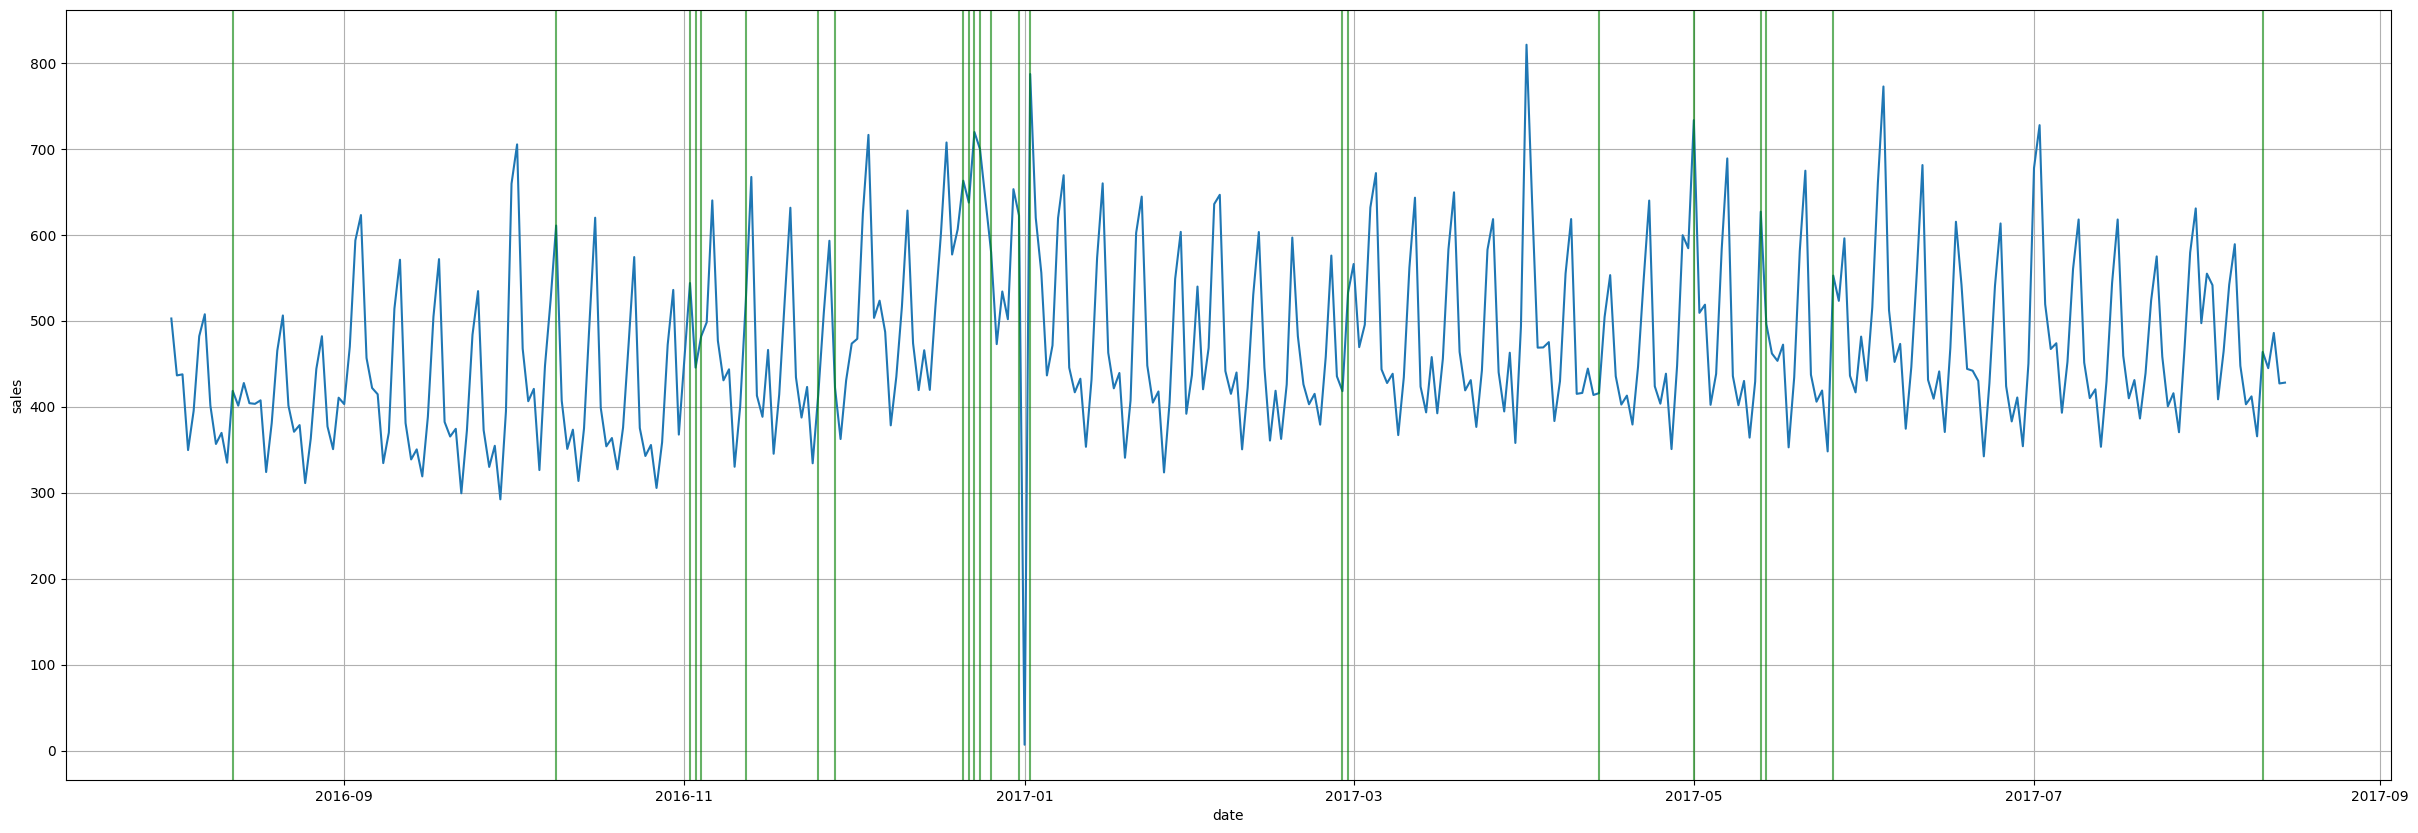

In [47]:
draw_numeric_features(all_sales_df, 'date', 'sales')
for date in all_sales_df.index:
    if date in national_hol_days['date'].values:
        plt.axvline(date, alpha=0.6, color='g')

In [48]:
national_hol_days = national_hol_days[['date','type']]
national_hol_days.head()

,date,type
14,2012-08-10,Holiday
20,2012-10-12,Transfer
21,2012-11-02,Holiday
22,2012-11-03,Holiday
31,2012-12-21,Additional


In [49]:
national_hol_days['type'].value_counts()

type
Event         56
Holiday       52
Additional    40
Transfer       8
Bridge         5
Work Day       5
Name: count, dtype: int64

In [50]:
national_hol_days.rename({'type': 'hol_type'}, inplace=True, axis=1)
national_hol_days['hol_type'] = national_hol_days['hol_type'].apply(lambda x: 'Holiday')

In [51]:
raw_df = pd.merge(left=raw_df, right=national_hol_days, on='date', how='left')
test_df = pd.merge(left=test_df, right=national_hol_days, on='date', how='left')

### Aggregate Features (Mean, Std)

In [52]:
training_date_min

Timestamp('2016-08-01 00:00:00')

In [53]:
date_min_to_lag = pd.to_datetime('2016-07-01')
date_min_to_lag

Timestamp('2016-07-01 00:00:00')

In [54]:
raw_df = raw_df[raw_df['date']>=date_min_to_lag]

In [55]:
raw_df.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,is_weekend,dcoilwtico,month_from,city,state,type,cluster,transactions,hol_type
2277396,2270268,2016-07-01,1,AUTOMOTIVE,8.0,1,2016,7,1,4,0,49.02,43,Quito,Pichincha,D,13,1876.0,NaN
2277397,2270269,2016-07-01,1,BABY CARE,0.0,0,2016,7,1,4,0,49.02,43,Quito,Pichincha,D,13,1876.0,NaN
2277398,2270270,2016-07-01,1,BEAUTY,5.0,1,2016,7,1,4,0,49.02,43,Quito,Pichincha,D,13,1876.0,NaN
2277399,2270271,2016-07-01,1,BEVERAGES,2298.0,8,2016,7,1,4,0,49.02,43,Quito,Pichincha,D,13,1876.0,NaN
2277400,2270272,2016-07-01,1,BOOKS,0.0,0,2016,7,1,4,0,49.02,43,Quito,Pichincha,D,13,1876.0,NaN


In [56]:
raw_df['date'] = raw_df['date'].apply(lambda x: np.nan if x in rows_to_drop.index else x)

In [57]:
raw_df.dropna(subset=['date'], inplace=True)

In [58]:
transactions_mean = raw_df['transactions'].mean()
raw_df.fillna({'transactions': transactions_mean}, inplace=True)

In [59]:
test_df.fillna({'transactions': transactions_mean}, inplace=True)

In [60]:
raw_df.fillna({'hol_type': 'No'}, inplace=True)
test_df.fillna({'hol_type': 'No'}, inplace=True)

In [61]:
day_of_week_mean = raw_df.groupby('day_of_week')['sales'].mean()

In [62]:
raw_df['day_of_week_mean'] = raw_df['day_of_week'].apply(lambda x: day_of_week_mean.get(x))
raw_df['day_of_week_mean'].value_counts()

day_of_week_mean
416.316703    103356
552.663574    101574
432.670683    101574
600.581344    101574
442.296525    101574
434.941178     99792
362.381255     99792
Name: count, dtype: int64

In [63]:
test_df['day_of_week_mean'] = test_df['day_of_week'].apply(lambda x: day_of_week_mean.get(x))

In [64]:
day_of_week_family_store_means = raw_df.groupby(['day_of_week','family','store_nbr'])['sales'].mean()
day_of_week_family_store_means

day_of_week  family      store_nbr
0            AUTOMOTIVE  1             4.000000
                         2             6.578947
                         3             8.929825
                         4             3.157895
                         5             5.789474
                                        ...    
6            SEAFOOD     50           27.321140
                         51           63.274596
                         52            3.475228
                         53            8.417298
                         54            2.368421
Name: sales, Length: 12474, dtype: float64

In [65]:
raw_df['day_of_week_family_store_mean'] = raw_df.apply(
    lambda x: day_of_week_family_store_means.get((x['day_of_week'],x['family'],x['store_nbr'])),
    axis=1
)

In [66]:
test_df['day_of_week_family_store_mean'] = test_df.apply(
    lambda x: day_of_week_family_store_means.get((x['day_of_week'],x['family'],x['store_nbr'])),
    axis=1
)

In [67]:
family_store_means = raw_df.groupby(['family','store_nbr'])['sales'].mean()

In [68]:
raw_df['family_store_mean'] = raw_df.apply(
    lambda x: family_store_means.get((x['family'],x['store_nbr'])),
    axis=1
)

In [69]:
test_df['family_store_mean'] = test_df.apply(
    lambda x: family_store_means.get((x['family'],x['store_nbr'])),
    axis=1
)

### Add lag features

In [70]:
test_df['sales'] = test_df['day_of_week_family_store_mean']

In [71]:
concat_df = pd.concat([raw_df, test_df])
concat_df

,id,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,...,month_from,city,state,type,cluster,transactions,hol_type,day_of_week_mean,day_of_week_family_store_mean,family_store_mean
2277396,2270268,2016-07-01,1,AUTOMOTIVE,8.000000,1,2016,7,1,4,...,43,Quito,Pichincha,D,13,1876.000000,No,432.670683,5.228070,4.025126
2277397,2270269,2016-07-01,1,BABY CARE,0.000000,0,2016,7,1,4,...,43,Quito,Pichincha,D,13,1876.000000,No,432.670683,0.000000,0.000000
2277398,2270270,2016-07-01,1,BEAUTY,5.000000,1,2016,7,1,4,...,43,Quito,Pichincha,D,13,1876.000000,No,432.670683,3.263158,3.298995
2277399,2270271,2016-07-01,1,BEVERAGES,2298.000000,8,2016,7,1,4,...,43,Quito,Pichincha,D,13,1876.000000,No,432.670683,2323.842105,2134.391960
2277400,2270272,2016-07-01,1,BOOKS,0.000000,0,2016,7,1,4,...,43,Quito,Pichincha,D,13,1876.000000,No,432.670683,0.526316,0.477387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,341.604089,1,2017,8,31,3,...,56,Quito,Pichincha,B,6,1637.808892,No,362.381255,341.604089,456.988965
28508,3029396,2017-08-31,9,PREPARED FOODS,101.891911,0,2017,8,31,3,...,56,Quito,Pichincha,B,6,1637.808892,No,362.381255,101.891911,118.367912
28509,3029397,2017-08-31,9,PRODUCE,1229.133589,1,2017,8,31,3,...,56,Quito,Pichincha,B,6,1637.808892,No,362.381255,1229.133589,1652.538175
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,11.250000,9,2017,8,31,3,...,56,Quito,Pichincha,B,6,1637.808892,No,362.381255,11.250000,13.721106


In [72]:
def create_lag_feature(df, lags, features):
    for feature in features:
        print(feature)
        for lag in lags:
            shifted = df[['date','store_nbr','family',feature]].copy()
            shifted.columns = ['date','store_nbr','family',f'{feature}_lag_{lag}']
            shifted['date'] = shifted['date'] + pd.to_timedelta(f'{lag} days')
            df = pd.merge(df, shifted, on=['date','store_nbr','family'], how='left')
    return df

In [73]:
concat_df = create_lag_feature(concat_df, [1,3,7,14,21], ['sales'])

sales


### Preprocessing

In [74]:
input_cols = concat_df.columns.tolist()
input_cols

['id',
 'date',
 'store_nbr',
 'family',
 'sales',
 'onpromotion',
 'year',
 'month',
 'day',
 'day_of_week',
 'is_weekend',
 'dcoilwtico',
 'month_from',
 'city',
 'state',
 'type',
 'cluster',
 'transactions',
 'hol_type',
 'day_of_week_mean',
 'day_of_week_family_store_mean',
 'family_store_mean',
 'sales_lag_1',
 'sales_lag_3',
 'sales_lag_7',
 'sales_lag_14',
 'sales_lag_21']

In [75]:
numeric_cols = ['onpromotion','dcoilwtico','transactions',
                'day_of_week_family_store_mean', 'family_store_mean',
                'year','month','day','day_of_week_mean','day_of_week',
                'month_from','store_nbr']
numeric_cols += [f'sales_lag_{lag}' for lag in [1,3,7,14,21]]
categorical_cols = ['family','city','state','type','cluster','hol_type']
len(numeric_cols + categorical_cols)

23

In [76]:
encoder = OrdinalEncoder()
encoder.fit(concat_df[categorical_cols])

OrdinalEncoder()

In [77]:
concat_df[categorical_cols] = encoder.transform(concat_df[categorical_cols])

In [78]:
concat_df[categorical_cols] = concat_df[categorical_cols].astype('int32')

In [79]:
concat_df.fillna(0, inplace=True)

### Split train, val and inputs, targets

In [80]:
validation_date_min = pd.to_datetime('2017-08-01')
testing_date_min = pd.to_datetime('2017-08-16')

In [81]:
train_df = concat_df[(concat_df['date']>=training_date_min)&(concat_df['date']<validation_date_min)]
val_df = concat_df[(concat_df['date']>=validation_date_min)&(concat_df['date']<testing_date_min)]
test_df = concat_df[concat_df['date']>=testing_date_min]

In [82]:
input_cols = numeric_cols + categorical_cols
train_inputs = train_df[input_cols]
val_inputs = val_df[input_cols]
test_inputs = test_df[input_cols]

In [83]:
train_targets = train_df['sales']
val_targets = val_df['sales']

In [84]:
%%time
mutual_info = mutual_info_classif(train_inputs, train_targets.astype('int64'), random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

CPU times: user 32min 18s, sys: 11 s, total: 32min 29s
Wall time: 12min 5s


,Numerical_Feature_MI
day_of_week_family_store_mean,1.802509
family_store_mean,1.642727
sales_lag_7,1.551438
sales_lag_14,1.488652
sales_lag_1,1.477621
sales_lag_21,1.442730
sales_lag_3,1.293224
family,0.971529
onpromotion,0.462803
hol_type,0.180992


## Training Model

In [85]:
cv = TimeSeriesSplit(n_splits=5)

In [86]:
scores = {
    'Training Score': [],
    'Validation Score': [],
    'LB Score': []
}

In [87]:
sample_df = train_df[train_df['date']>=pd.to_datetime('2017-02-01')]
inputs = sample_df[input_cols]
targets = sample_df['sales']

### XGB

In [88]:
"""param_dis = {
    'n_estimators': np.arange(100,600,150),
    'max_depth': np.arange(8,17,2),
    'learning_rate': loguniform(0.009,0.25),
    'reg_lambda': loguniform(1e-5,5),
    'subsample': loguniform(0.5,1),
    'min_child_weight': loguniform(0.4,5),
    'eval_metric': ['rmse'],
    'tree_method': ['hist'],
    'colsample_bytree': loguniform(0.25,1),
    'nthread': [2],
    'n_jobs': [-1],
    'device': ['cuda'],
    'max_bin': [256,1024]
}
search = RandomizedSearchCV(XGBRegressor(), param_dis, 
                            n_iter=80, refit=True,
                            scoring = 'neg_root_mean_squared_error',
                            cv=cv, verbose=3)
%%time
search.fit(inputs, targets)"""

"param_dis = {\n    'n_estimators': np.arange(100,600,150),\n    'max_depth': np.arange(8,17,2),\n    'learning_rate': loguniform(0.009,0.25),\n    'reg_lambda': loguniform(1e-5,5),\n    'subsample': loguniform(0.5,1),\n    'min_child_weight': loguniform(0.4,5),\n    'eval_metric': ['rmse'],\n    'tree_method': ['hist'],\n    'colsample_bytree': loguniform(0.25,1),\n    'nthread': [2],\n    'n_jobs': [-1],\n    'device': ['cuda'],\n    'max_bin': [256,1024]\n}\nsearch = RandomizedSearchCV(XGBRegressor(), param_dis, \n                            n_iter=80, refit=True,\n                            scoring = 'neg_root_mean_squared_error',\n                            cv=cv, verbose=3)\n%%time\nsearch.fit(inputs, targets)"

In [89]:
"""result_df = pd.DataFrame(search.cv_results_)
top_best_params_df = result_df.sort_values(by=['split4_test_score','mean_test_score'],ascending=False).head(5)
top_best_params = top_best_params_df['params']
top_best_params = top_best_params.values
top_best_params"""

"result_df = pd.DataFrame(search.cv_results_)\ntop_best_params_df = result_df.sort_values(by=['split4_test_score','mean_test_score'],ascending=False).head(5)\ntop_best_params = top_best_params_df['params']\ntop_best_params = top_best_params.values\ntop_best_params"

In [90]:
top_best_params = [
       {'colsample_bytree': 0.3331250116332325, 'device': 'cuda', 'eval_metric': 'rmsle', 'learning_rate': 0.0181226730304106, 'max_bin': 1024, 'max_depth': 8, 'min_child_weight': 3.127122583259609, 'n_estimators': 550, 'n_jobs': -1, 'nthread': 2, 'reg_lambda': 0.0004113550658953047, 'subsample': 0.7252646649139289, 'tree_method': 'hist'},
       {'colsample_bytree': 0.33583672916758756, 'device': 'cuda', 'eval_metric': 'rmsle', 'learning_rate': 0.03449909954600302, 'max_bin': 1024, 'max_depth': 10, 'min_child_weight': 2.465352953032767, 'n_estimators': 550, 'n_jobs': -1, 'nthread': 2, 'reg_lambda': 0.6985085849201808, 'subsample': 0.6335028852136396, 'tree_method': 'hist'},
       {'colsample_bytree': 0.5679549731012677, 'device': 'cuda', 'eval_metric': 'rmsle', 'learning_rate': 0.01725069773248936, 'max_bin': 1024, 'max_depth': 14, 'min_child_weight': 1.2363814258051748, 'n_estimators': 250, 'n_jobs': -1, 'nthread': 2, 'reg_lambda': 8.06810175159492e-05, 'subsample': 0.5027602865177483, 'tree_method': 'hist'},
       {'colsample_bytree': 0.9888407129960985, 'device': 'cuda', 'eval_metric': 'rmsle', 'learning_rate': 0.012234215730496467, 'max_bin': 1024, 'max_depth': 16, 'min_child_weight': 3.630359577639024, 'n_estimators': 550, 'n_jobs': -1, 'nthread': 2, 'reg_lambda': 0.5250422241638455, 'subsample': 0.5228433184772314, 'tree_method': 'hist'},
       {'colsample_bytree': 0.3085623103540962, 'device': 'cuda', 'eval_metric': 'rmsle', 'learning_rate': 0.018220363022718268, 'max_bin': 1024, 'max_depth': 14, 'min_child_weight': 1.2498781328609796, 'n_estimators': 550, 'n_jobs': -1, 'nthread': 2, 'reg_lambda': 0.3324327251950589, 'subsample': 0.5300646920079768, 'tree_method': 'hist'}
]

In [91]:
best_params = {
 'colsample_bytree': 0.36046107942302996,
 'device': 'cuda',
 'eval_metric': 'rmsle',
 'learning_rate': 0.09798294248984837,
 'max_bin': 1024,
 'max_depth': 10,
 'min_child_weight': 2.7429366083887046,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': 2,
 'reg_lambda': 7.852787189067641e-05,
 'subsample': 0.7816850989913537,
 'tree_method': 'hist'
}
top_best_params.append(best_params)

In [92]:
%%time
for params in top_best_params:
    xgb = XGBRegressor(**params)
    eval_set = (val_inputs, val_targets)
    xgb.fit(train_inputs, train_targets)
    train_preds = xgb.predict(train_inputs)
    train_preds = pd.Series(train_preds).apply(lambda x: 0 if x<0 else x)
    val_preds = xgb.predict(val_inputs) 
    val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
    train_score = np.sqrt(mean_squared_log_error(train_targets, train_preds))
    val_score = np.sqrt(mean_squared_log_error(val_targets, val_preds))
    print(train_score, val_score)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:45:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.6604226728725184 0.5756278647144863
0.6254109897182231 0.5705393254103507
0.987495190045642 0.9375893078193099
0.4879905133968939 0.46465439235490785
0.558047689978897 0.5427350528766461
0.5157063772689364 0.4317289029571606
CPU times: user 2min 6s, sys: 2.41 s, total: 2min 9s
Wall time: 1min 56s


We choose 4th and 6th params to next_view

In [93]:
top_best_params = [top_best_params[3], top_best_params[5]]

In [94]:
# Switch to tweedie, which is fit better for outliers
top_best_params[0] = {
 'colsample_bytree': 0.9888407129960985,
 'device': 'cuda',
 'objective': 'reg:tweedie',
 'learning_rate': 0.012234215730496467,
 'max_bin': 1024,
 'max_depth': 16,
 'min_child_weight': 3.630359577639024,
 'n_estimators': 550,
 'n_jobs': -1,
 'nthread': 2,
 'reg_lambda': 0.5250422241638455,
 'subsample': 0.5228433184772314,
 'tree_method': 'hist'
}
top_best_params[1] = {
 'colsample_bytree': 0.36046107942302996,
 'device': 'cuda',
 'objective': 'reg:tweedie',
 'learning_rate': 0.09798294248984837,
 'max_bin': 1024,
 'max_depth': 10,
 'min_child_weight': 2.7429366083887046,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': 2,
 'reg_lambda': 7.852787189067641e-05,
 'subsample': 0.7816850989913537,
 'tree_method': 'hist'
}

We see that tweedie look like make high performance. So we choose them

In [95]:
%%time
model = XGBRegressor(**top_best_params[0])
model.fit(train_inputs, train_targets)

CPU times: user 1min 38s, sys: 1.54 s, total: 1min 39s
Wall time: 1min 37s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9888407129960985, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.012234215730496467, max_bin=1024,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=3.630359577639024, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=550,
             n_jobs=-1, nthread=2, num_parallel_tree=None, ...)

In [96]:
train_preds = model.predict(train_inputs)
train_preds = pd.Series(train_preds).apply(lambda x: 0 if x<0 else x)
val_preds = model.predict(val_inputs) 
val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
train_score = np.sqrt(mean_squared_log_error(train_targets, train_preds))
val_score = np.sqrt(mean_squared_log_error(val_targets, val_preds))

scores['Training Score'].append(train_score)
scores['Validation Score'].append(val_score)

In [97]:
preds = model.predict(test_inputs)
preds = pd.Series(preds).apply(lambda x: 0 if x<0 else x)
sub_df['sales'] = preds
sub_df.to_csv('/kaggle/working/submission_xgb1.csv', index=None) # 0.45991
scores['LB Score'].append(0.45991)

In [98]:
%%time
model = XGBRegressor(**top_best_params[1])
model.fit(train_inputs, train_targets)

CPU times: user 4.65 s, sys: 51 ms, total: 4.7 s
Wall time: 2.94 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.36046107942302996, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09798294248984837, max_bin=1024,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2.7429366083887046, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, nthread=2, num_parallel_tree=None, ...)

In [99]:
train_preds = model.predict(train_inputs)
train_preds = pd.Series(train_preds).apply(lambda x: 0 if x<0 else x)
val_preds = model.predict(val_inputs) 
val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
train_score = np.sqrt(mean_squared_log_error(train_targets, train_preds))
val_score = np.sqrt(mean_squared_log_error(val_targets, val_preds))

scores['Training Score'].append(train_score)
scores['Validation Score'].append(val_score)

In [100]:
preds = model.predict(test_inputs)
preds = pd.Series(preds).apply(lambda x: 0 if x<0 else x)
sub_df['sales'] = preds
sub_df.to_csv('/kaggle/working/submission_xgb2.csv', index=None) # 0.61984
scores['LB Score'].append(0.61984)

### LGBM

In [101]:
param_dis = {
    'num_leaves': np.arange(35,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(90,541,40),
    'learning_rate': loguniform(0.005,0.24),
    'max_depth': np.arange(25,55,3),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(5,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [0]
}

In [102]:
"""search = RandomizedSearchCV(LGBMRegressor(),
                            param_dis,
                            n_iter=80,
                            scoring='neg_root_mean_squared_error', cv=cv,
                            refit=True, verbose=3)
%%time
search.fit(inputs, targets)"""

"search = RandomizedSearchCV(LGBMRegressor(),\n                            param_dis,\n                            n_iter=80,\n                            scoring='neg_root_mean_squared_error', cv=cv,\n                            refit=True, verbose=3)\n%%time\nsearch.fit(inputs, targets)"

In [103]:
"""result_df = pd.DataFrame(search.cv_results_)
top_best_params_df = result_df.sort_values(by=['split4_test_score','mean_test_score'],ascending=False).head(5)
top_best_params = top_best_params_df['params']
top_best_params = top_best_params.values
top_best_params"""

"result_df = pd.DataFrame(search.cv_results_)\ntop_best_params_df = result_df.sort_values(by=['split4_test_score','mean_test_score'],ascending=False).head(5)\ntop_best_params = top_best_params_df['params']\ntop_best_params = top_best_params.values\ntop_best_params"

In [104]:
top_best_params = [
       {'colsample_bytree': 0.38612290634905316, 'learning_rate': 0.019448085029714964, 'max_depth': 37, 'min_child_samples': 25, 'min_child_weight': 0.00010651167765603759, 'min_split_gain': 0.00039389436877888974, 'n_estimators': 410, 'n_jobs': -1, 'num_leaves': 266, 'random_state': 42, 'reg_alpha': 0.00038857689748331755, 'reg_lambda': 1.2175779341817934e-05, 'subsample': 0.4073841770422224, 'verbose': 0},
       {'colsample_bytree': 0.3386001410442769, 'learning_rate': 0.022779541153407735, 'max_depth': 28, 'min_child_samples': 25, 'min_child_weight': 0.0276611691463869, 'min_split_gain': 7.589060344403361e-07, 'n_estimators': 450, 'n_jobs': -1, 'num_leaves': 84, 'random_state': 42, 'reg_alpha': 0.1746737596599672, 'reg_lambda': 3.9912043804770336, 'subsample': 0.8728392525742567, 'verbose': 0},
       {'colsample_bytree': 0.375754758717469, 'learning_rate': 0.033213178346248574, 'max_depth': 40, 'min_child_samples': 25, 'min_child_weight': 0.0027926133427973493, 'min_split_gain': 4.596433722541404e-07, 'n_estimators': 330, 'n_jobs': -1, 'num_leaves': 273, 'random_state': 42, 'reg_alpha': 0.000487961284784787, 'reg_lambda': 0.010766375126135697, 'subsample': 0.9014681156157839, 'verbose': 0},
       {'colsample_bytree': 0.3806352712367178, 'learning_rate': 0.01651747301395488, 'max_depth': 28, 'min_child_samples': 17, 'min_child_weight': 0.00010689096147244734, 'min_split_gain': 9.169187689210781e-05, 'n_estimators': 530, 'n_jobs': -1, 'num_leaves': 182, 'random_state': 42, 'reg_alpha': 0.009475243725026587, 'reg_lambda': 0.0060514685962175865, 'subsample': 0.93166862550276, 'verbose': 0},
       {'colsample_bytree': 0.36602405625363577, 'learning_rate': 0.04773306256315782, 'max_depth': 40, 'min_child_samples': 25, 'min_child_weight': 0.04245040228259431, 'min_split_gain': 1.2207585070920103e-08, 'n_estimators': 130, 'n_jobs': -1, 'num_leaves': 189, 'random_state': 42, 'reg_alpha': 0.26325764137533386, 'reg_lambda': 0.0010243864855692202, 'subsample': 0.841925274821497, 'verbose': 0}
]

In [105]:
%%time
for params in top_best_params:
    lgbm = LGBMRegressor(**params)
    eval_set = (val_inputs, val_targets)
    lgbm.fit(train_inputs, train_targets)
    train_preds = lgbm.predict(train_inputs)
    train_preds = pd.Series(train_preds).apply(lambda x: 0 if x<0 else x)
    val_preds = lgbm.predict(val_inputs) 
    val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
    train_score = np.sqrt(mean_squared_log_error(train_targets, train_preds))
    val_score = np.sqrt(mean_squared_log_error(val_targets, val_preds))
    print(train_score, val_score)

0.6130544642896212 0.508575462010582
0.6795250940496859 0.5973014687199941
0.5759965674929466 0.4765429994911554
0.6270190289370502 0.5166784623117449
0.7436227950422233 0.6530877796283351
CPU times: user 5min 55s, sys: 1.46 s, total: 5min 56s
Wall time: 1min 32s


We choose 3rd one and view with objective=tweedie

In [106]:
best_params = top_best_params[2]

In [107]:
best_params['objective'] = 'tweedie'
best_params

{'colsample_bytree': 0.375754758717469,
 'learning_rate': 0.033213178346248574,
 'max_depth': 40,
 'min_child_samples': 25,
 'min_child_weight': 0.0027926133427973493,
 'min_split_gain': 4.596433722541404e-07,
 'n_estimators': 330,
 'n_jobs': -1,
 'num_leaves': 273,
 'random_state': 42,
 'reg_alpha': 0.000487961284784787,
 'reg_lambda': 0.010766375126135697,
 'subsample': 0.9014681156157839,
 'verbose': 0,
 'objective': 'tweedie'}

In [108]:
%%time
lgbm = LGBMRegressor(**best_params)
lgbm.fit(train_inputs, train_targets)

CPU times: user 1min 10s, sys: 334 ms, total: 1min 10s
Wall time: 18.4 s


LGBMRegressor(colsample_bytree=0.375754758717469,
              learning_rate=0.033213178346248574, max_depth=40,
              min_child_samples=25, min_child_weight=0.0027926133427973493,
              min_split_gain=4.596433722541404e-07, n_estimators=330, n_jobs=-1,
              num_leaves=273, objective='tweedie', random_state=42,
              reg_alpha=0.000487961284784787, reg_lambda=0.010766375126135697,
              subsample=0.9014681156157839, verbose=0)

In [109]:
train_preds = lgbm.predict(train_inputs)
train_preds = pd.Series(train_preds).apply(lambda x: 0 if x<0 else x)
val_preds = lgbm.predict(val_inputs) 
val_preds = pd.Series(val_preds).apply(lambda x: 0 if x<0 else x)
train_score = np.sqrt(mean_squared_log_error(train_targets, train_preds))
val_score = np.sqrt(mean_squared_log_error(val_targets, val_preds))

scores['Training Score'].append(train_score)
scores['Validation Score'].append(val_score)

In [110]:
train_score,val_score

(0.3787867211006121, 0.38799176061650475)

In [111]:
preds = lgbm.predict(test_inputs)
preds = pd.Series(preds).apply(lambda x: 0 if x<0 else x)
sub_df['sales'] = preds
sub_df.to_csv('/kaggle/working/submission_lgbm.csv', index=None) # 0.67048
scores['LB Score'].append(0.67048)

### View score

In [112]:
pd.DataFrame(scores, index=['XGB1','XGB2','LGBM'])

,Training Score,Validation Score,LB Score
XGB1,0.309953,0.380869,0.45991
XGB2,0.381577,0.392849,0.61984
LGBM,0.378787,0.387992,0.67048


In [113]:
sub_df = pd.read_csv('/kaggle/working/submission_xgb1.csv')
sub_df.head()

,id,sales
0,3000888,3.797704
1,3000889,0.000011
2,3000890,4.372155
3,3000891,2275.423096
4,3000892,0.025924


In [114]:
sub_df.to_csv('/kaggle/working/submission.csv', index=None)
sub_df.head()

,id,sales
0,3000888,3.797704
1,3000889,0.000011
2,3000890,4.372155
3,3000891,2275.423096
4,3000892,0.025924
